# "Probabilistic Assessment of Safety Underreporting"
> "Awesome summary"

- toc: false
- branch: master
- badges: true
- comments: false
- author: Yves Barmaz
- categories: [bayesian modeling, clinical quality]

This post presents a practical application of probabilistic programming and explores some technical details of a recent [preprint](https://www.medrxiv.org/content/10.1101/2020.12.18.20245068v1) where Timothé Ménard and I proposed a Bayesian model for the detection of adverse event underreporting in clinical trials.

A clinical trial is usually run across several investigator sites, which are required to report to the trial sponsor adverse events experienced by enrolled subjects. This is necessary to assess the safety of the intervention under investigation. Underreporting from certain sites has been a recurrent issue. Trial sponsors and health authorities rely on audits and inspections to ensure completeness of the collected safety data. This effort can and should be informed by statistical analysis of the adverse event reporting process with a focus on identifying sites that report at lower rates.

The relevant data is the count of adverse events reported by every patient enrolled in a study and their site assignment. To illustrate our methodology, we use data from the control arm of NCT00617669, an oncology study from [Project Data Sphere](https://www.projectdatasphere.org/).

In [16]:
#hide_input

import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

data = pd.read_csv('my_data/ae_data.csv')
data.head(5)

,study,site_number,patnum,ae_count_cumulative
0,NCT00617669,3001,16,4
1,NCT00617669,3001,456,1
2,NCT00617669,3002,171,2
3,NCT00617669,3002,248,2
4,NCT00617669,3002,304,1


Bayesian data analysis combines expert knowledge on the process of interest, expressed as a probabilistic model, with observed data to infer posterior distributions of the model parameters. These posterior distributions allow us to quantify uncertainties and risks, and to compute posterior expectation values of quantities of interest.

[Hierarchical models](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html) provide a natural framework for subgroup analysis, where similar entities such as the sites of a single study can share information while maintaining a certain degree of independence. In our situation, at the bottom of the hierarchy, the count of adverse events reported by the $n_i$ patients of site $i$ can be modelled with a Poisson distribution, $Y_i \sim \mathrm{Poi}(\lambda_i)$. The $N_{\mathrm{sites}}$ Poisson rates $\lambda_i$ can in turn be modelled as realizations of a random variable unique to the whole study with Gamma distribution $\Gamma(\alpha, \beta)$. The parameters $\alpha$ and $\beta$ are unknown, so we assume a vague prior for both of them, $\alpha \sim \mathrm{Exp}(1)$ and $\beta \sim \mathrm{Exp}(10)$. The full joint distribution
$$
P(\alpha, \beta, \lambda_i, Y_{i,j}) = P(\alpha)P(\beta)\prod_{i=1}^{N_{\mathrm{sites}}}P(\lambda_i\vert\alpha,\beta)\prod_{j=1}^{n_i} P(Y_{i,j}\vert \lambda_i)
$$
is summarized in the following graphical representation.

![](my_images/graph_ae_reporting.png)

Numerical modelling of such joint distributions is made easy by probabilistic programming libraries such as [TensorFlow-Probability](https://www.tensorflow.org/probability) (utilized here), [Stan](https://mc-stan.org/), [PyMC3](https://docs.pymc.io/) or [Pyro](https://pyro.ai/).

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

sites = tf.constant(data['site_number'])
observed_ae = tf.constant(data['ae_count_cumulative'])

unique_sites, sites_idx, sites_counts = tf.unique_with_counts(sites)

ae_per_site = tf.RaggedTensor.from_value_rowids(
    values=observed_ae,
    value_rowids=sites_idx)

mdl_ae = tfd.JointDistributionSequential([
    #alpha
    tfd.Gamma(1, 1, name='alpha'),
    #beta
    tfd.Gamma(1, 10, name='beta'),
    #Poisson rates for each sites
    lambda beta, alpha: tfd.Sample(tfd.Gamma(alpha, beta), sample_shape=unique_sites.shape, name='rates'),
    #observed AEs
    lambda rates: tfd.Independent(
        tfd.Poisson(tf.gather(rates, sites_idx, axis=-1)), reinterpreted_batch_ndims=1, name='observations')
])

In Bayesian inference, the analytical derivation of the posterior distribution is often impossible, but the same probabilistic programming libraries provide efficient implementations of MCMC algorithms that return samples of the posterior distribution.

In [8]:
#collapse-hide
dtype = tf.dtypes.float32
nchain = 10
burnin=1000
num_steps=10000
alpha0, beta0, rates0, _ = mdl_ae.sample(nchain)
init_state = [alpha0, beta0, rates0]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1, .1]]
target_log_prob_fn = lambda *init_state: mdl_ae.log_prob(
    list(init_state) + [tf.cast(observed_ae, dtype=dtype)])

# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Exp(),
    tfb.Exp(),
    tfb.Exp()
]

@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=num_steps, burnin=burnin):
    
    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.is_accepted
               )

    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=3,
        step_size=step_size),
      bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=kernel,
      num_adaptation_steps=burnin
    )

    # Sampling from the chain.
    [alpha, beta, rates], is_accepted = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=hmc,
        trace_fn=trace_fn)
    return alpha, beta, rates, is_accepted

In [ ]:
#hide
alpha, beta, rates, is_accepted = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

alpha_ = alpha[burnin:,:]
alpha_ = tf.reshape(alpha_, [alpha_.shape[0]*alpha_.shape[1]])
beta_ = beta[burnin:,:]
beta_ = tf.reshape(beta_, [beta_.shape[0]*beta_.shape[1]])
rates_ = rates[burnin:,:]
rates_ = tf.reshape(rates_, [rates_.shape[0]*rates_.shape[1], rates_.shape[2]])

rates_dist_ = tfd.Gamma(alpha_[:,tf.newaxis], beta_[:, tf.newaxis])
rates_cdf_ = rates_dist_.cdf(rates_)

In [9]:
#hide
posterior = {unique_sites.numpy()[i]: np.swapaxes(rates[2000:, :, i].numpy(), 1, 0) for i in range(4)}
posterior['alpha'] = tf.transpose(alpha[2000:, :]).numpy()
posterior['beta'] = tf.transpose(beta[2000:, :]).numpy()

az_trace = az.from_dict(posterior=posterior)

To assess convergence, we sample several chains that we can inspect visually (here with the [ArviZ](https://arviz-devs.github.io/arviz/index.html) package) to make sure that they converge to the same distribution, mix well, and do not display pathological autocorrelations.

In [10]:
#hide
is_accepted.numpy().mean()

0.72371

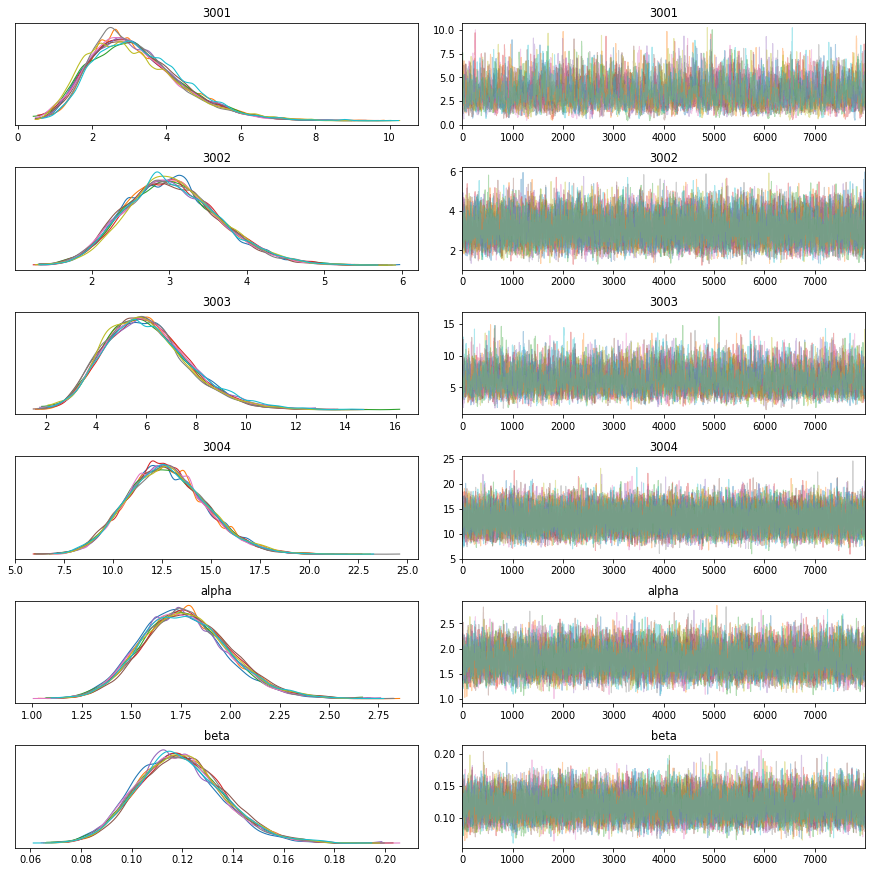

In [11]:
#hide_input
az.plot_trace(az_trace)
plt.show()

If we have to monitor several studies, we might want to automate that process. In that case, we can compute [statistics](https://arxiv.org/abs/1903.08008) of the sampled chains such as effective sample sizes or $\hat{R}$ and implement automatic checks, for instance that $\hat{R}$ is sufficiently close to 1.

In [12]:
#hide_input
az.summary(az_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
3001,3.193,1.246,1.081,5.565,0.022,0.016,3146.0,3146.0,2849.0,3764.0,1.0
3002,3.050,0.616,1.964,4.250,0.006,0.004,11787.0,11787.0,11502.0,17056.0,1.0
3003,6.043,1.695,3.084,9.280,0.022,0.015,6031.0,6031.0,5772.0,9765.0,1.0
3004,12.764,2.030,9.037,16.628,0.014,0.010,19819.0,19819.0,19489.0,28664.0,1.0
alpha,1.774,0.223,1.364,2.192,0.003,0.002,6352.0,6352.0,6253.0,16128.0,1.0
beta,0.119,0.017,0.087,0.151,0.000,0.000,7576.0,7576.0,7441.0,18742.0,1.0


From the samples $(\hat{\alpha}, \hat{\beta}, \hat{\lambda}_i)$ of the Markov chain, we can estimate the posterior risk of underreporting. One way to do it is to compute the left tail area of each $\lambda_i$ (remember that the index $i$ enumerates the sites) under the distribution $\Gamma(\hat{\alpha}, \hat{\beta})$ and average it along the trace of the Markov chain. This corresponds to the probability that a Poisson rate drawn randomly from the study level distribution falls below the inferred Poisson rate of site $i$, or, more explicitly, that a reference site from the same study would report less adverse events.

In [15]:
#hide_
mean_rates = tf.math.reduce_mean(rates_, axis=0)
std_rates = tf.math.reduce_std(rates_, axis=0)

rates_tail = tf.math.reduce_mean(rates_cdf_, axis=0)

summary_df = pd.DataFrame({'site': unique_sites.numpy(),
                           'mean_ae_rate': mean_rates.numpy(),
                           'std_ae_rate': std_rates.numpy(),
                           'rate_tail_area': rates_tail.numpy(),
                           'observed_ae': [obs.numpy() for obs in list(ae_per_site)]
                          })

pd.options.display.float_format = '{:,.2f}'.format
#summary_df.sort_values('rate_tail_area', ascending=True).head(10)
summary_df.head(10)

,site,mean_ae_rate,std_ae_rate,rate_tail_area,observed_ae
0,3001,3.20,1.25,0.09,"[4, 1]"
1,3002,3.05,0.62,0.08,"[2, 2, 1, 2, 5, 5, 5, 1]"
2,3003,6.04,1.69,0.22,"[7, 4]"
3,3004,12.76,2.03,0.52,"[3, 27, 8]"
4,3005,9.35,2.10,0.37,"[12, 6]"
5,3006,3.69,1.32,0.11,"[2, 4]"
6,3007,6.03,2.31,0.22,[5]
7,3008,17.95,1.72,0.69,"[11, 4, 16, 31, 23, 23]"
8,3009,6.52,1.76,0.24,"[6, 6]"
9,3010,14.71,0.92,0.59,"[21, 10, 6, 17, 10, 7, 26, 19, 18, 1, 18, 23, ..."


A lower value of this rate tail area thus indicates a higher risk of underreporting. This metric can be used by auditors and inspectors to prioritize their activities. Moreover, since it is the probability of a specified event, one can immediately compare the rate tail areas of sites from different studies. This is especially interesting for quality programs that oversee several trials.

This approach demonstrates the flexibility of Bayesian methods to build models that answer specific questions about a given process. In this example, the reporting rates of the different sites are the quantities of interest, but they are unobserved and have to be inferred from the available data with a mathematical model. The user-friendly API of modern probabilistic programming libraries combined with efficient inference algorithms have been making this type of workflow much easier than in the past and will certainly fuel a broader adoption in sectors that have not been traditionally driven by quantitative insights.